In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms



IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='/content/drive/MyDrive/stl10', download=True, split='train', transform=composed_train)
testset  = torchvision.datasets.STL10(root='/content/drive/MyDrive/stl10', download=True, split='test',  transform=composed_test)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [ ]:

X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data),torch.mean(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.9895), tensor(2.1309), tensor(-0.2098))


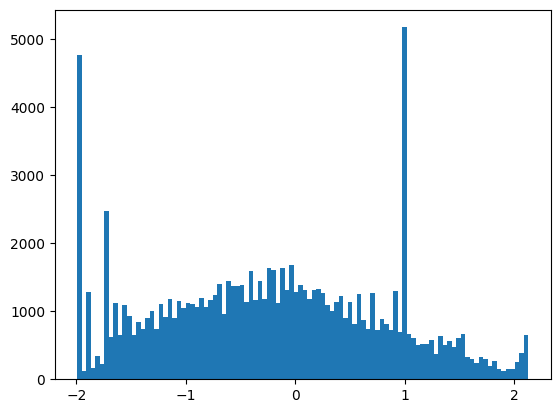

In [ ]:
plt.hist(X.data.numpy().flatten(),100);

In [ ]:
pre_trained_model = torch.jit.load('/content/drive/MyDrive/CNN.pt')

In [ ]:
# Define the custom MLP on top of the pre-trained model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
print(pre_trained_model)

RecursiveScriptModule(
  original_name=CNN
  (cnn1): RecursiveScriptModule(original_name=Conv2d)
  (maxpool1): RecursiveScriptModule(original_name=MaxPool2d)
  (cnn2): RecursiveScriptModule(original_name=Conv2d)
  (maxpool2): RecursiveScriptModule(original_name=MaxPool2d)
  (cnn3): RecursiveScriptModule(original_name=Conv2d)
  (maxpool3): RecursiveScriptModule(original_name=MaxPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (drop): RecursiveScriptModule(original_name=Dropout)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)


In [ ]:
# Freeze the pre-trained model
for param in pre_trained_model.parameters():
    param.requires_grad = False


In [ ]:
# Get the output size of the pre-trained model

 pretrained_output_size = pre_trained_model.fc3.out_features

In [ ]:
pretrained_output_size

10

In [ ]:
# Create the combined model
combined_model = nn.Sequential(
    pre_trained_model,
    MLP(pretrained_output_size, 512, 10)  # Assuming 10 classes for STL10
)

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = combined_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch%5==0:
       print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/100], Loss: 1.0893678665161133
Epoch [6/100], Loss: 1.0625438690185547
Epoch [11/100], Loss: 1.3149986267089844
Epoch [16/100], Loss: 1.3932621479034424
Epoch [21/100], Loss: 1.1946327686309814
Epoch [26/100], Loss: 1.1658451557159424
Epoch [31/100], Loss: 1.2289167642593384
Epoch [36/100], Loss: 1.2164143323898315
Epoch [41/100], Loss: 1.2535054683685303
Epoch [46/100], Loss: 1.2745925188064575
Epoch [51/100], Loss: 0.8270484209060669
Epoch [56/100], Loss: 1.2938587665557861
Epoch [61/100], Loss: 0.8993343710899353
Epoch [66/100], Loss: 1.0315221548080444
Epoch [71/100], Loss: 1.1319973468780518
Epoch [76/100], Loss: 0.7187872529029846
Epoch [81/100], Loss: 1.2074344158172607
Epoch [86/100], Loss: 1.2090743780136108
Epoch [91/100], Loss: 0.7767075896263123
Epoch [96/100], Loss: 1.2782245874404907


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

y_pred = []
y_true = []


for x, y in test_loader:

    z = combined_model(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f'confusion_matrix: \n{cf_matrix}\n accuracy:{acc}')

confusion_matrix: 
[[538  47  23  10   6   3   4   1  79  89]
 [ 38 454  12 114  41  39  16  70  10   6]
 [ 11  14 626  13   0   8   9  12  18  89]
 [  9  43   6 445  81  68  49  74   7  18]
 [  9  35   2  90 531  28  77  20   3   5]
 [  6  55   7 144  57 281 142  98   6   4]
 [  2  19   4  51  31  59 569  47   2  16]
 [  4  90   8 190  39 104  77 275   1  12]
 [ 55  13  24  17   6   4   1   5 602  73]
 [ 33   5  87  27   2   6  30  19  38 553]]
 accuracy:0.60925


In [ ]:
pre_trained_model = torch.jit.load('/content/drive/MyDrive/res_CNN.pt')

In [ ]:
# Freeze the pre-trained model
for param in pre_trained_model.parameters():
    param.requires_grad = False

In [ ]:
# Get the output size of the pre-trained model
pretrained_output_size = pre_trained_model.fc3.out_features


In [ ]:
# Create the combined model
combined_model = nn.Sequential(
    pre_trained_model,
    MLP(pretrained_output_size, 512, 10)  # Assuming 10 classes for STL10
)

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = combined_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch%5==0:
       print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/100], Loss: 1.584426999092102
Epoch [6/100], Loss: 1.1607478857040405
Epoch [11/100], Loss: 1.0841668844223022
Epoch [16/100], Loss: 1.0622496604919434
Epoch [21/100], Loss: 1.2453480958938599
Epoch [26/100], Loss: 1.0368144512176514
Epoch [31/100], Loss: 0.9433500170707703
Epoch [36/100], Loss: 1.3448230028152466
Epoch [41/100], Loss: 1.1164411306381226
Epoch [46/100], Loss: 1.2845114469528198
Epoch [51/100], Loss: 1.1970692873001099
Epoch [56/100], Loss: 0.8916528224945068
Epoch [61/100], Loss: 1.306792974472046
Epoch [66/100], Loss: 1.042923092842102
Epoch [71/100], Loss: 1.08961021900177
Epoch [76/100], Loss: 1.22860586643219
Epoch [81/100], Loss: 1.1797456741333008
Epoch [86/100], Loss: 0.9276352524757385
Epoch [91/100], Loss: 1.2762635946273804
Epoch [96/100], Loss: 1.057108759880066


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

y_pred = []
y_true = []


for x, y in test_loader:

    z = combined_model(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f'confusion_matrix: \n{cf_matrix}\n accuracy:{acc}')

confusion_matrix: 
[[590  32  12   4   8   5   5   4 102  38]
 [ 42 455  14  62  31  42  15 119  15   5]
 [  7  12 648   5   1  12   6   7  25  77]
 [  7  45   5 327  88 142  37 125  14  10]
 [  6  32   1  48 580  41  42  41   5   4]
 [  2  38   2  76  62 361 131 110   9   9]
 [  6  12   3  15  31  99 563  54   5  12]
 [  4  97   6  99  65 128  61 329   0  11]
 [ 52  16  15   8   3   3   4   9 655  35]
 [ 32  17  77   6   2   9  22  21  84 530]]
 accuracy:0.62975


## VGG

In [ ]:
vggnet = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.9MB/s]


In [ ]:
# Freeze all layers (final layer changed later)
for p in vggnet.parameters():
    p.requires_grad = False

In [ ]:

# change the final layer (this time soft-coded!)
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features,10)

In [ ]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vggnet.parameters(),lr=0.001)

In [ ]:
numepochs = 2

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)


# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vggnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # forward pass and loss
    yHat = vggnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  vggnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:
    # forward pass and loss
    with torch.no_grad():
      yHat = vggnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')



Finished epoch 1/2. Test accuracy = 90.92%
Finished epoch 2/2. Test accuracy = 90.98%


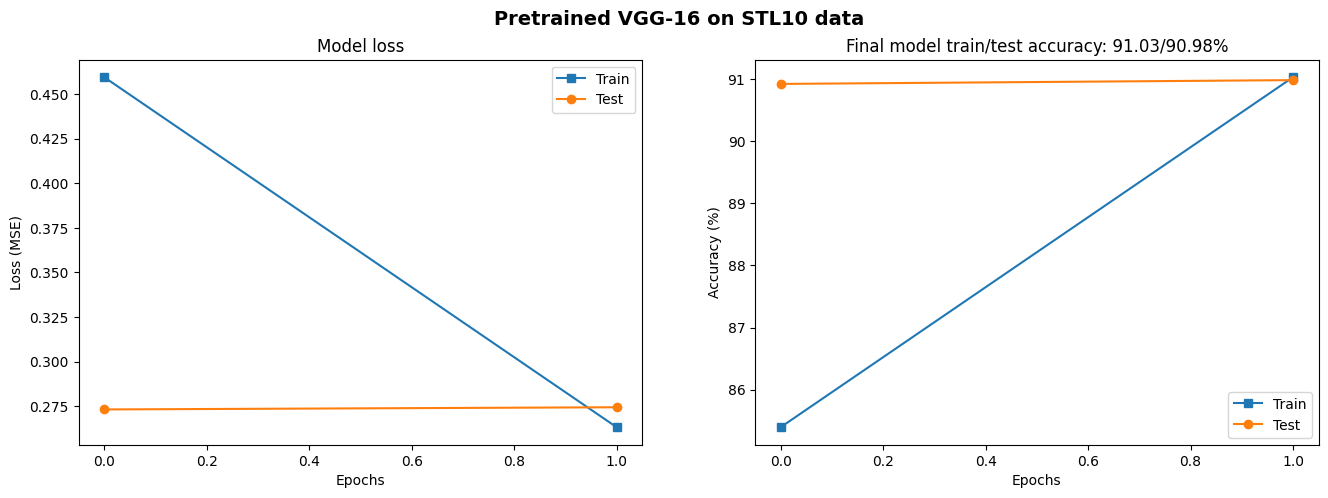

In [ ]:


fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()



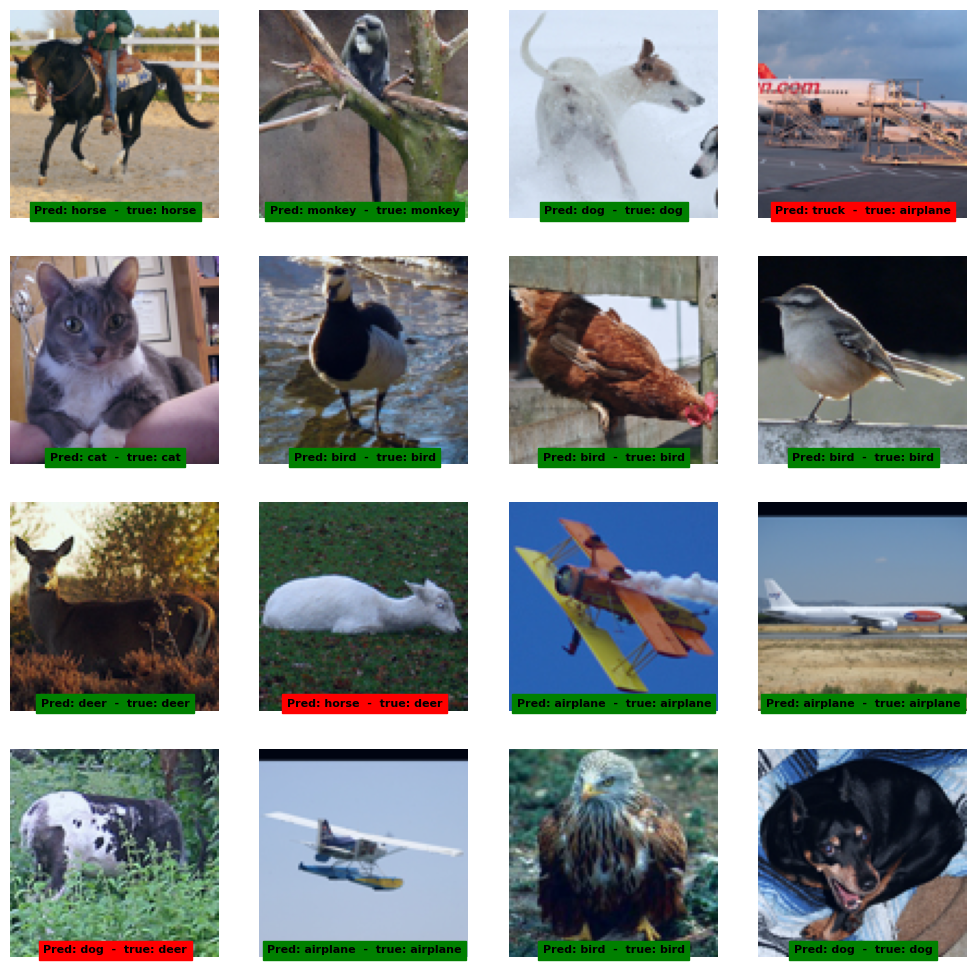

In [ ]:
X,y = next(iter(test_loader))
vggnet.eval()
predictions = torch.argmax( vggnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

## Inception

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# Define custom MLP classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Load pre-trained Inception model
inception_model = models.inception_v3(pretrained=True)

# Freeze the weights of the pre-trained model
for param in inception_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer of Inception for the desired output classes
inception_model.fc = CustomClassifier(inception_model.fc.in_features, num_classes=10)  # Assuming 10 classes for STL10

# Define STL10 data transformations
transform = transforms.Compose([
    transforms.Resize(299),  # InceptionV3 expects input size to be (299, 299)
    transforms.ToTensor(),
])

# Load STL10 dataset
stl10_train_dataset = datasets.STL10(root='/content/drive/MyDrive/stl10', split='train', download=True, transform=transform)
stl10_train_loader = DataLoader(stl10_train_dataset, batch_size=128, shuffle=True)

stl10_test_dataset  = torchvision.datasets.STL10(root='/content/drive/MyDrive/stl10', download=True, split='test',  transform=transform)
stl10_test_loader = DataLoader(stl10_test_dataset, batch_size=128)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    for inputs, labels in stl10_train_loader:

        # Forward pass
        outputs, _ = inception_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(inception_model.state_dict(), 'inception_stl10_classification.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 0.8522
Epoch [2/2], Loss: 0.4098


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# Define custom MLP classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Load pre-trained Inception model
inception_model = models.inception_v3(pretrained=True)

# Freeze the weights of the pre-trained model
for param in inception_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer of Inception for the desired output classes
inception_model.fc = CustomClassifier(inception_model.fc.in_features, num_classes=10)

inception_model.load_state_dict(torch.load('./inception_stl10_classification.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [13]:
from torchvision import models, transforms, datasets

transform = transforms.Compose([
    transforms.Resize(299),  # InceptionV3 expects input size to be (299, 299)
    transforms.ToTensor(),
])

# Load STL10 dataset
stl10_test_dataset = datasets.STL10(root='/content/drive/MyDrive/stl10', split='test', download=True, transform=transform)
stl10_test_loader = DataLoader(stl10_train_dataset, batch_size=128)

Files already downloaded and verified


In [15]:
from sklearn.metrics import accuracy_score,confusion_matrix

y_pred = []
y_true = []

inception_model.eval()

for inputs, labels in stl10_test_loader:

    outputs = inception_model(inputs)
    _, outputs = torch.max(outputs, 1)
    pred = outputs.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    y = labels.data.cpu().numpy()
    y_true.extend(y) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f'confusion_matrix: \n{cf_matrix}\n accuracy:{acc}')

confusion_matrix: 
[[779   1   1   0   0   1   1   0  17   0]
 [  5 777   0   4   0   8   1   5   0   0]
 [  1   0 775   1   0   0   2   0   1  20]
 [  0   8   0 721  19  40   4   8   0   0]
 [  1  10   0  11 738  11  26   3   0   0]
 [  2   2   0   7   5 757  24   3   0   0]
 [  1   1   0   0  11   6 778   0   0   3]
 [  1   7   0   5   4   6   3 774   0   0]
 [  4   1   0   0   0   1   0   0 793   1]
 [ 16   1  12   0   0   0   4   0   5 762]]
 accuracy:0.95675
